In [154]:
from pathos.multiprocessing import ProcessPool
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import cython

In [155]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [156]:
"""
rho = 0.85
h = 0.016
m = 48
T = 1
M = 6 # cube root of number of unit cells in the L^3 volume, gives N=864 particles
L = (4*6**3)/rho
sigma = 3.405 #Angstrom
epsilon = 119.8 #K
# Todo: Scale time
"""

'\nrho = 0.85\nh = 0.016\nm = 48\nT = 1\nM = 6 # cube root of number of unit cells in the L^3 volume, gives N=864 particles\nL = (4*6**3)/rho\nsigma = 3.405 #Angstrom\nepsilon = 119.8 #K\n# Todo: Scale time\n'

In [157]:
%%cython
import numpy as np
from itertools import product
from tqdm import tqdm

cdef float rho = 0.85
cdef float h = 0.016
cdef int m = 48 # Be aware that m is also defined later outside of the cython
cdef float T = 2.0
cdef int M = 2 # cube root of number of unit cells in the L^3 volume, gives N=864 particles
cdef float L = np.cbrt((4*M**3)/rho)

list_pbc = list(product([0, 1, -1], repeat=3))
list_pbc = L*np.array(list_pbc)

def f_optimized(double[:] r_i, double[:] r_j):
    cdef int d
    cdef double[:] vec_L_min
    cdef double[:] r_ij_candidates = np.zeros(27)
    
    for i, vec_L in enumerate(list_pbc):
        for d in range(3):
            r_ij_candidates[i] += (r_i[d] - r_j[d] + L*vec_L[d])**2
        
    cdef int index_L_min = np.argmin(r_ij_candidates)
    vec_L_min = L * list_pbc[index_L_min]
    cdef double r_ij = (r_ij_candidates[index_L_min])
    
    cdef double f_x = m * (r_i[0] - r_j[0] + vec_L_min[0]) * (r_ij**(-14) + 0.5 * r_ij**(-8))
    cdef double f_y = m * (r_i[1] - r_j[1] + vec_L_min[1]) * (r_ij**(-14) + 0.5 * r_ij**(-8))
    cdef double f_z = m * (r_i[2] - r_j[2] + vec_L_min[2]) * (r_ij**(-14) + 0.5 * r_ij**(-8))
    
    return np.array([f_x, f_y, f_z])

def f(r_i, r_j):
    #Todo: Cut potential for r_ij > sigma
    
    r_ij_candidates = [np.sum([(r_i[d]-r_j[d]+vec_L[d])**2 for d in range(3)]) for vec_L in list_pbc]
    index_L_min = np.argmin([r_ij_candidates])#list_pbc[index_min]
    vec_L_min = list_pbc[index_L_min]
    r_ij = np.sqrt(r_ij_candidates[index_L_min])
    f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    return np.array([f_x, f_y, f_z])

def arange_without(i):
    original_array = np.arange(4*M**3)
    result_array = original_array[original_array != i]
    return result_array

def F(r):
    return np.array([np.sum(np.array([f_optimized(r[i], r[k]) for k in arange_without(i)]), axis=0) for i in range(r.shape[0])])
    #return [f(r[i], r[k]) for k in arange_without(i)] pool.map()
    #pool = ProcessPool(nodes=4)
    #results = pool.map(f_subprocess, (r for i in range(r.shape[0])), range(r.shape[0]))
    #return np.array(results)

def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next

def verlet_algorithm(r_0, v_0, num_steps):
    list_r = [r_0]
    list_v = [v_0]
    for t in tqdm(range(num_steps)):
        r_new, v_new = verlet_step(list_r[-1], list_v[-1])
        list_r.append(r_new)
        list_v.append(v_new)
    return np.array(list_r), np.array(list_v)

def build_fcc():
    """
    :param M: integer. cube root of Number of unit cells
    :return: fcc grid for the L*L cube (np.array of shape (n_points, 3))
    """
    range_values_sc = np.linspace(-L/2, L/2, M+1)
    length_edge = np.abs(range_values_sc[0]-range_values_sc[1]) #L/(rho-1)
    sc_grid = np.array(list(product(range_values_sc, repeat=3)))
    sc_grid = sc_grid[sc_grid[:, 0] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 1] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 2] != -L/2]
    missing_points = []
    for point in sc_grid:
        p1 = [point[0]+0.5*length_edge, point[1], point[2]+0.5*length_edge]
        p2 = [point[0]+0.5*length_edge, point[1]+0.5*length_edge, point[2]]
        p3 = [point[0], point[1]+0.5*length_edge, point[2]+0.5*length_edge]
        missing_points.append(p1)
        missing_points.append(p2)
        missing_points.append(p3)
    missing_points = np.array(missing_points)
    x = sc_grid[:,0]
    y = sc_grid[:,1]
    z = sc_grid[:,2]
    x_m = missing_points[:,0]
    y_m = missing_points[:,1]
    z_m = missing_points[:,2]
    fcc_grid = np.concatenate([sc_grid, missing_points])

    return fcc_grid

def Temperature(v):
    return 16*np.mean([(v_i[0]**2)+(v_i[1]**2)+(v_i[2]**2) for v_i in v])

performance hint: C:\Users\corin\.ipython\cython\_cython_magic_61d92e9a8c060eb184f99b2cd49a5444f72916b1.pyx:22:28: Index should be typed for more efficient access


Content of stdout:
_cython_magic_61d92e9a8c060eb184f99b2cd49a5444f72916b1.c
C:\Users\corin\.ipython\cython\_cython_magic_61d92e9a8c060eb184f99b2cd49a5444f72916b1.c(24062): warning C4305: "=": Verkrzung von "double" in "float"
C:\Users\corin\.ipython\cython\_cython_magic_61d92e9a8c060eb184f99b2cd49a5444f72916b1.c(24071): warning C4305: "=": Verkrzung von "double" in "float"
   Bibliothek "C:\Users\corin\.ipython\cython\Users\corin\.ipython\cython\_cython_magic_61d92e9a8c060eb184f99b2cd49a5444f72916b1.cp311-win_amd64.lib" und Objekt "C:\Users\corin\.ipython\cython\Users\corin\.ipython\cython\_cython_magic_61d92e9a8c060eb184f99b2cd49a5444f72916b1.cp311-win_amd64.exp" werden erstellt.
Code wird generiert.
Codegenerierung ist abgeschlossen.

In [158]:
T = 2.0
sigma = 3.405 #Angstrom
epsilon = 119.8 #K
m = 48 # Be careful, m is also defined in the cython

r_0 = build_fcc()
N_0 = r_0.shape[0]
#np.random.uniform(-L/2, L/2, (N_0, 3)) #randomly between 0 and L with gaussian distribution, mean 0, std sqrt(kT^*/m^*), m^* = 48, k = 1, are the velocities normally distributed in every seperate direction?
v_0 = np.random.normal(0,np.sqrt(T/epsilon*m), (N_0, 3))
tp = np.sqrt(48*epsilon/(m*sigma**2)) #*t

"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""

"\nr_0: Initial positions of the system\n    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle\nv_0: Initial velocities of the system particles\n    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle\n"

In [159]:
print(N_0)

32


Text(0.5, 0.92, 'Initial state of the Argon ')

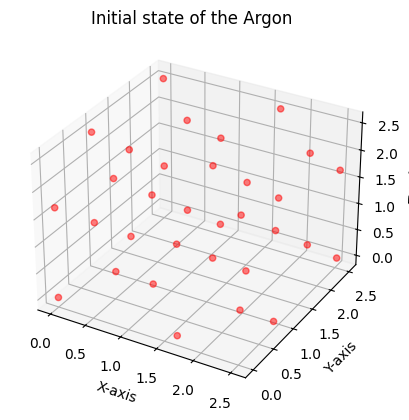

In [160]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='r', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

In [161]:
t_max = 1000

r_total, v_total = verlet_algorithm(r_0, v_0, t_max)

100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s]


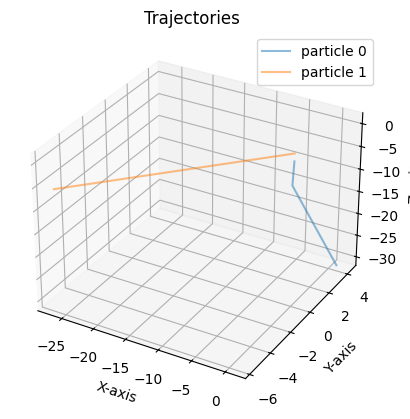

In [162]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(r_total[:,0,0], r_total[:,0,1], r_total[:,0,2], alpha=0.5, markersize= 10, label= "particle 0")
ax.plot(r_total[:,1,0], r_total[:,1,1], r_total[:,1,2], alpha=0.5, markersize=10, label= "particle 1")

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectories ')
plt.legend()

Text(0, 0.5, '$T^*$')

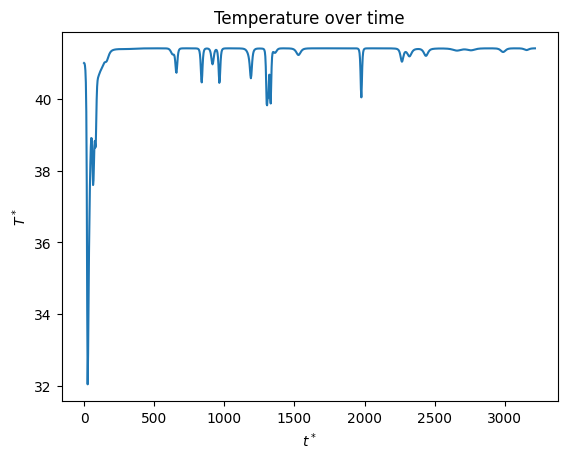

In [163]:
T_total = [Temperature(v_t) for v_t in v_total]
plt.plot(np.arange(t_max+1)*tp, T_total)
plt.title("Temperature over time")
plt.xlabel("$t^*$")
plt.ylabel("$T^*$")

In [164]:
T_total

[41.00191358405465,
 40.99130795010336,
 40.93396863233086,
 40.79137861718013,
 40.457429022111256,
 39.63705219148079,
 37.6381154592317,
 34.16658928067854,
 32.03949737604324,
 32.91219036281392,
 34.513751079585475,
 35.73856963362229,
 36.717374754258444,
 37.549107810279224,
 38.19210008530885,
 38.65286071670488,
 38.9095130677448,
 38.90090069696743,
 38.57354950307911,
 38.01210325234942,
 37.59811908535194,
 37.72428629147806,
 38.23897222497319,
 38.69706471509279,
 38.829251243784405,
 38.642261171815804,
 38.69339874640094,
 39.331303059431505,
 39.98566432933699,
 40.347656942859174,
 40.512910973612314,
 40.589621052488816,
 40.63351851688764,
 40.668914295800235,
 40.70359942343683,
 40.73746443652419,
 40.768527464129804,
 40.79623648621675,
 40.82201614083273,
 40.84816702140992,
 40.876412669473844,
 40.9069397235167,
 40.93825596380463,
 40.967758268036974,
 40.99265097360072,
 41.01086808771896,
 41.021829701662305,
 41.02696345007833,
 41.02980496419198,
 41.0353

Text(0.5, 1.0, 'Force that acts on particle 0 in x-direction over time')

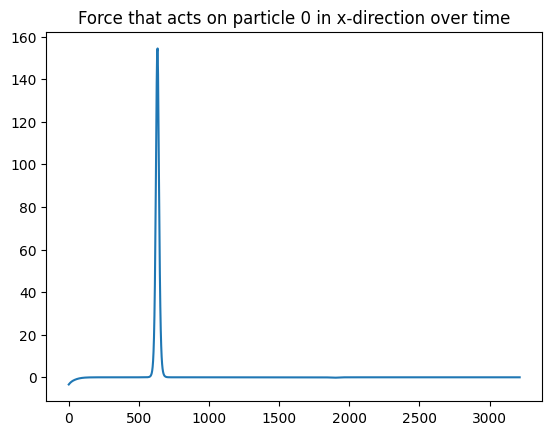

In [165]:
plt.plot(np.arange(t_max+1)*tp, [F(r_total[t])[0,0] for t in range(t_max+1)])
plt.title("Force that acts on particle 0 in x-direction over time")

In [166]:
r_total

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.67576718e+00],
        [ 0.00000000e+00,  1.67576718e+00,  0.00000000e+00],
        ...,
        [ 2.51365077e+00,  1.67576718e+00,  2.51365077e+00],
        [ 2.51365077e+00,  2.51365077e+00,  1.67576718e+00],
        [ 1.67576718e+00,  2.51365077e+00,  2.51365077e+00]],

       [[-4.88873850e-03,  2.98468805e-03, -3.35622840e-02],
        [-2.66289002e-02, -5.55510502e-03,  1.66837770e+00],
        [ 9.09665064e-03,  1.67718114e+00,  4.73209346e-03],
        ...,
        [ 2.53140086e+00,  1.69326730e+00,  2.50880367e+00],
        [ 2.51574210e+00,  2.51617923e+00,  1.66575799e+00],
        [ 1.67829463e+00,  2.50919157e+00,  2.49380813e+00]],

       [[-9.79404208e-03,  5.95357375e-03, -6.71397158e-02],
        [-5.32791867e-02, -1.11315265e-02,  1.66098955e+00],
        [ 1.81679811e-02,  1.67859999e+00,  9.43470111e-03],
        ...,
        [ 2.54917162e+00,  1.71076062e+00,

In [167]:
v_total

array([[[-0.30498473,  0.1871044 , -2.09708124],
        [-1.66346492, -0.34635278, -0.46184451],
        [ 0.56938191,  0.08837061,  0.2965971 ],
        ...,
        [ 1.10853925,  1.09375567, -0.3037851 ],
        [ 0.12986665,  0.15718726, -0.62557628],
        [ 0.15796333, -0.27954166, -1.24100663]],

       [[-0.3060638 ,  0.18604917, -2.09811602],
        [-1.66497451, -0.34786019, -0.46180093],
        [ 0.56774938,  0.08852516,  0.2948344 ],
        ...,
        [ 1.11002628,  1.09354473, -0.30224485],
        [ 0.13150005,  0.15879996, -0.62564931],
        [ 0.15801057, -0.27788973, -1.23920181]],

       [[-0.30705825,  0.18511474, -2.09899026],
        [-1.66618841, -0.3490547 , -0.46169228],
        [ 0.56620001,  0.08900371,  0.29287683],
        ...,
        [ 1.11121966,  1.09297148, -0.30092077],
        [ 0.13306731,  0.16030868, -0.62588648],
        [ 0.15820544, -0.27630591, -1.23709726]],

       ...,

       [[ 0.14970609,  0.28535192, -1.92208078],
        [-1

In [168]:
rho = 0.85
h = 0.016
m = 48 # Be aware that m is also defined later outside of the cython
T = 2.0
M = 6 # cube root of number of unit cells in the L^3 volume, gives N=864 particles
L = (4*6**3)/rho
r_1, v_1 = verlet_step(r_0, v_0)
"""
def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next
"""

v_tilde = v_0 + h/(2*m)*F(r_0)
print(v_tilde)

[[-0.30554614  0.18654299 -2.09764265]
 [-1.66430619 -0.34719405 -0.46184268]
 [ 0.56854064  0.08837244  0.29575583]
 [-0.8288459   0.02100658  1.37627126]
 [ 1.08786667  0.06945034  1.48342121]
 [-0.10520359  1.98930788  0.66764527]
 [ 1.11130498 -0.44742872 -1.93545275]
 [-1.5265963  -0.72742052 -0.90374325]
 [-1.13188739 -0.27140537 -0.37505183]
 [-0.22303411  0.12578049 -0.93389252]
 [ 0.55995401  0.49704267 -0.90374245]
 [ 0.86417793  1.95638913 -0.66579544]
 [ 1.05163926 -0.47877244 -0.15416849]
 [ 1.37709846 -0.51377567  0.18080938]
 [ 0.96671421  1.1612967   0.38739479]
 [ 1.23926473  0.90267956 -1.26242929]
 [-0.27306996  0.24005568 -0.58293678]
 [-0.66246043 -0.12843896  0.28688662]
 [ 0.59811265  0.0394214   0.38021537]
 [-1.47029622  0.3264959   1.21863831]
 [ 0.79308501 -1.21179225 -1.05178957]
 [ 1.75588495  0.52559686 -0.84137446]
 [ 0.17949902  1.61288667  0.5393584 ]
 [ 0.83749964  1.39281576  0.44764227]
 [ 0.02441687  0.26389198 -1.07407847]
 [-0.43477909 -0.7632933 

In [169]:
print(F(r_1))

[[-3.10595051e+00 -2.96293877e+00 -2.84021484e+00]
 [-4.00991335e+00 -3.99683772e+00  2.50492724e-01]
 [-4.74754246e+00  9.16321983e-01 -5.52858638e+00]
 [-5.65921323e+00  1.05504044e-01 -1.80037637e+00]
 [-1.16305194e+00 -4.17048543e+00 -5.51895940e+00]
 [ 2.10353567e+00 -1.05791526e+01 -3.55532980e+00]
 [-2.24320591e+00 -1.14907567e+00 -5.48181864e+00]
 [ 4.03703472e+00  1.77262787e+00  4.22743692e+00]
 [ 9.70824022e-01 -6.16789730e+00 -8.14781076e-03]
 [ 1.40144535e+00 -1.74727880e-01 -5.79120958e+00]
 [-6.45902946e+00 -1.60599100e-01  1.38081034e+00]
 [-1.93953229e+00 -8.78037345e+00  6.41952140e+00]
 [-5.14426526e+00  1.66337198e+00 -2.00719491e+00]
 [-6.52474226e+00  9.69287944e-02  5.10135793e+00]
 [-4.15598414e+00 -2.06940485e+00 -2.54635762e+00]
 [-5.00948223e-01  4.09284573e+00 -4.32470631e+00]
 [-4.07149131e+00  4.61927333e+00  5.63148166e-01]
 [ 9.05764796e-01  7.16292120e-01  6.74110167e+00]
 [-3.17746665e+00  7.17895804e+00  7.32526852e-01]
 [-2.45468329e+00  3.01597026e+

In [170]:
def f(r_i, r_j):
    #Todo: Cut potential for r_ij > sigma
    
    r_ij_candidates = [np.sum([(r_i[d]-r_j[d]+vec_L[d])**2 for d in range(3)]) for vec_L in list_pbc]
    index_L_min = np.argmin([r_ij_candidates])#list_pbc[index_min]
    vec_L_min = list_pbc[index_L_min]
    r_ij = np.sqrt(r_ij_candidates[index_L_min])
    print(r_ij)
    f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    print(r_i[2]-r_j[2]+vec_L_min[2])
    print(r_ij**(-14))
    return np.array([f_x, f_y, f_z])

print(f(r_0[3], r_0[4]))

2.9025139031388267
1.675767183303833
3.320165084934332e-07
[-0.00801089  0.00801089  0.00801089]


In [171]:
r_0

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.67576718],
       [0.        , 1.67576718, 0.        ],
       [0.        , 1.67576718, 1.67576718],
       [1.67576718, 0.        , 0.        ],
       [1.67576718, 0.        , 1.67576718],
       [1.67576718, 1.67576718, 0.        ],
       [1.67576718, 1.67576718, 1.67576718],
       [0.83788359, 0.        , 0.83788359],
       [0.83788359, 0.83788359, 0.        ],
       [0.        , 0.83788359, 0.83788359],
       [0.83788359, 0.        , 2.51365077],
       [0.83788359, 0.83788359, 1.67576718],
       [0.        , 0.83788359, 2.51365077],
       [0.83788359, 1.67576718, 0.83788359],
       [0.83788359, 2.51365077, 0.        ],
       [0.        , 2.51365077, 0.83788359],
       [0.83788359, 1.67576718, 2.51365077],
       [0.83788359, 2.51365077, 1.67576718],
       [0.        , 2.51365077, 2.51365077],
       [2.51365077, 0.        , 0.83788359],
       [2.51365077, 0.83788359, 0.        ],
       [1.